In [1]:
from itertools import product

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Package years for convenience
years = [year for year in range(1980, 2017)]

# Part I: Processing Yearly Data

I will now process the yearly data.  There's a systematic set of things needed to be done to the data each year.  This involves routine data cleaning, but also:

* Removing movies that don't have a Runtime, Release data, Production Budget, and Domestic Total Gross.
* Cutting off movies that don't have a Production Budget larger than 5 million.
* Splitting the Release Date into the Release Year and Release Month.
* Converting all dollar amounts to units = millions of dollars.

In [2]:
# Clean "Domestic Total Gross" col (in minutes)
def clean_domestic(gross_str):
    # Removing "DomesticLifetime..." substring
    if "D" in gross_str:
        first_D = gross_str.find("D")
        gross_str = gross_str[:first_D].strip()  

    gross_str = gross_str.replace(",", "").replace("$", "").strip()
    integer_in_millions = float(gross_str)

    return str(integer_in_millions / 10**6)


In [3]:
# Clean "Production Budget" col (in millions of $)

def clean_budget(val_str):
    val_str = val_str.replace("$", "")
    
    # "$ xxx,xxx,xxx" format
    if "," in val_str:
        val_str = val_str.replace(",", "").strip()
        val_str = str(float(val_str) / 10**6)
        
    # "$xxx million" format
    elif "million" in val_str:
        val_str = val_str.replace("million", "").strip()
    
    # "$xxx,xxx" format
    else:
        val_str = val_str.replace(",", "").strip()
        val_str = str(int(val_str) / 10**6)

    return val_str

In [4]:
# Clean "Runtime" (in minutes)

def clean_runtime(time_str):
    time_str = time_str.replace("min.", "").replace("hrs.", " ")
    vals = [val for val in time_str.split() if val not in ["", " "]]

    hrs = int(vals[0])
    mins = int(vals[1])

    return str(hrs*60 + mins)


In [5]:
# Clean up the date
# "Month DD, YYYY" -> "Year", "Month" as two cols

def make_year_col(date_str):
    _, year = date_str.split(",")
    return year.strip()

    
def make_month_col(date_str):
    month, _ = date_str.split(",")
    return month.split()[0].strip()


In [6]:
# Apply all of these data processing methods to the yearly data

def process_movie_df(mov_df):
    # Drop Outright Garbage
    mov_df.drop(columns=["Unnamed: 0"], inplace=True)
    mov_df.dropna(subset=["Production Budget", "Domestic Total Gross", "Runtime"], axis=0, inplace=True)

    # Clean up data in cols
    mov_df["Domestic Total Gross"] = mov_df["Domestic Total Gross"].apply(clean_domestic)
    mov_df["Production Budget"] = mov_df["Production Budget"].apply(clean_budget)
    mov_df["Runtime"] = mov_df["Runtime"].apply(clean_runtime)
    
    # Create Month and Year Columns
    mov_df["Release Month"] = mov_df["Release Date"].apply(make_month_col)
    mov_df["Release Year"] = mov_df["Release Date"].apply(make_year_col)
    mov_df.drop(columns=["Release Date"], inplace=True)
    
    # Format numeric columns
    mov_df["Production Budget"] = pd.to_numeric(mov_df["Production Budget"])
    mov_df["Domestic Total Gross"] = pd.to_numeric(mov_df["Domestic Total Gross"])
    mov_df["Release Year"] = pd.to_numeric(mov_df["Release Year"])
    
    # Create a cutoff for movies with too low of a budget
    mov_df = mov_df[mov_df["Production Budget"] > 5]
    
    return mov_df

# N.B. Only 5 entries don't have a runtime

In [7]:
mov_dfs = []

for year in years:
    raw_df = pd.read_csv(f"data/movies_{year}.csv")
    processed_df = process_movie_df(raw_df)
    mov_dfs.append(processed_df)
    
movs_df = pd.concat(mov_dfs, ignore_index=True)

movs_df.head()

,Name,Domestic Total Gross,Distributor,Genre,MPAA Rating,Runtime,Production Budget,Director,Producer,Actor,Release Month,Release Year
0,The Empire Strikes Back,209.398025,Fox,Sci-Fi Fantasy,PG,129,18.0,Irvin Kershner,George Lucas,"Anthony Daniels,Peter Mayhew,Mark Hamill,Harri...",May,1980
1,The Shining,44.017374,Warner Bros.,Horror,R,146,19.0,Stanley Kubrick,NaN,Jack Nicholson,May,1980
2,Dressed to Kill,31.899000,Orion Pictures,Thriller,R,105,6.5,Brian De Palma,NaN,Michael Caine,June,1980
3,The Island (1980),15.716828,Universal,Adventure,R,114,22.0,NaN,NaN,Michael Caine,June,1980
4,Used Cars,11.715321,Columbia,Comedy,R,113,8.0,Robert Zemeckis,Steven Spielberg,Kurt Russell,July,1980


In [8]:
len(movs_df)

2637

Okay, there's one garbage entry. Let's fix this one by hand (I refer to Box Office Mojo).  It appears there were no other scraping errors.

In [9]:
movs_df.iloc[2326]

Name                                                       The LEGO Movie
Domestic Total Gross                                              257.761
Distributor                                                  Warner Bros.
Genre                                                           Animation
MPAA Rating                                                            PG
Runtime                                                               100
Production Budget                                                      60
Director                                      Phil Lord,Chris Miller (II)
Producer                Doug Davison,t   m   "   >   R   o   y       L...
Actor                   Elizabeth Banks,Will Ferrell,Anthony Daniels,C...
Release Month                                                    February
Release Year                                                         2014
Name: 2326, dtype: object

In [10]:
movs_df.iloc[2326, movs_df.columns.get_loc("Producer")] = "Doug Davison,Roy Lee,Dan Lin"

---
## Quick Data Viz

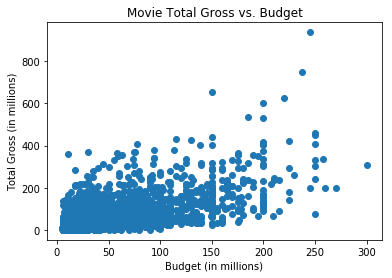

In [11]:
x = movs_df["Production Budget"]
y = movs_df["Domestic Total Gross"]

plt.scatter(x,y)
plt.title("Movie Total Gross vs. Budget")
plt.xlabel("Budget (in millions)")
plt.ylabel("Total Gross (in millions)")
plt.show();

In [12]:
movs_df.groupby(["Release Month"])["Domestic Total Gross"].mean()

Release Month
April         40.009972
August        51.075036
December      74.723360
February      51.524987
January       36.501044
July          94.598780
June         101.970745
March         56.025121
May          114.067399
November      78.852285
October       36.137034
September     32.385007
Name: Domestic Total Gross, dtype: float64

In [13]:
movs_df.to_csv("data/movie_database.csv")

---
# Scoring All "Players" --Actors, Directors, Producers, Genres-- For Their "Trendiness"


## Part 1: Writing the Scoring Utilities
I need to write some utilities to handle converting actor's, producer's, etc, past success in recent movies into a numerical score that I can use in my regression.

__These utilities do the following:__

1. We utilities require a player kind ("Actor", "Director", "Producer", "Genre"), the list of unique players (e.g. for Director, ["George Lucas", "Peter Jackson", ...]), the cleaned DataFrame of the movies, and the span of time (of the player's recent career) to look at.

1. These utilities take each player of that kind (e.g. Ewan McGregor for "Actor") every year, and checks all of their work of that kind over the past span of time (defaults to previous 7 years) and takes the average of their work as their "trendiness."  So if Ewan McGregor did three movies in the past 7 years that made [100, 200, 300] million, he would have a Actor Score of 200 for that year.  If this year he had another movie that made 400 million, his score would increase next year. 

1. After that data base has been created for each player over each year, this information is mapped back to the original __movs_df__ DataFrame.  Movies take the trendiness score by taking the sum of each individual player score.  So in other words, if there's three actors with a 7 year average of 100 mil per movie, then that movie will get an Actor Score of 300.  The __movs_df__ DataFrame then drops the text-based col for the new numerical scored column.

In [14]:
def fill_in_playerscores(playerkind, all_players, movs_df, years, span=7):
    """
    Take movie DataFrame, construct player scores for each year, and fill in movie database with a new column named "[playerkind] Score", where playerkind = col name, e.g. "Actor", "Director".
    """
    
    # For performance, filter out non-empty player fields and unused cols
    filtered_movs_df = (movs_df[["Release Year", "Domestic Total Gross", playerkind]]
                                .dropna(subset=[playerkind], axis=0))
    
    # Make BLANK DataFrame of Player Scores.
    player_scores_df = pd.DataFrame(
        {player : np.zeros(len(years)) for player in all_players},
        index=years)
    
    # Calculate and fill-in the DataFrame of Player Scores.
    for year, player in product(years, all_players):
        player_in_mov = lambda mov_players: True if player in str(mov_players) else False
        
        player_scores_df.loc[year][player] = score_player(player_in_mov, year,
                                                          span, playerkind, filtered_movs_df)
    
    # Map the "Player Scores" back into the original Movies DataFrame.
    movs_df[f"{playerkind} Trendy Score"] = movs_df.apply(fill_in_a_score,
                                                   player_scores_df=player_scores_df,
                                                   playerkind=playerkind,
                                                   axis=1)
    
    movs_df.drop(columns=[playerkind], inplace=True)
    
    return movs_df


In [15]:
def score_player(player_in_mov, year, span, playerkind, movs_df):
    """Score player by the average of their movies' DTG over the past (span) years."""
    
    #filtered_movs_df = (movs_df.dropna(subset=["Actor"], axis=0))
    
    # Grab only for most recent movies
    recent_movs_df = (movs_df[(movs_df["Release Year"] < year)
                              & (movs_df["Release Year"] >= (year-span))])
    
    # Filter down further to ones the player's been in.
    player_mask = recent_movs_df[playerkind].apply(player_in_mov)
    player_recent = recent_movs_df[player_mask]
    
    # Return average gross of player's recent movies
    if player_recent.empty:
        return 0
    else:
        return player_recent["Domestic Total Gross"].mean()


In [16]:
def fill_in_a_score(row, playerkind, player_scores_df):
    """Fills in player's score values in original movie DataFrame."""
    
    mov_year = row["Release Year"]
    score = 0

    for player in player_scores_df.columns:       
        # Force types to strings; e.g. if player = "50 Cent", forces false float back to str.
        player, player_list = str(player), str(row[playerkind])

        # If actor in movie, add their score from scores DataFrame
        if player in player_list:
            score += player_scores_df.loc[mov_year][player]
        
        # This is a patch for Genre, since "Unknown"s have no correlation with one another
        if player == "Unknown":
            score = 0
    
    return score


---
## Part II: Scoring All of the Players

Now I will generate the pieces of data needed to compute the scoring system for the players (chiefly, the unique list of actors, directors, genres, etc).  Here I write a quick utility to perform this task.

In [17]:
def make_complete_player_list(playerkind, movs_df, seperator=",", removechar="/"):
    all_players = []
    movs = movs_df.dropna(subset=[playerkind], axis=0)

    for mov_players in movs[playerkind]:
        mov_players = str(mov_players).replace(removechar, " ")
        mov_players = [player.strip() for player in mov_players.split(seperator) if player != ""]
        
        all_players.extend(mov_players)

    # Remove and order non-unique actors
    return sorted(list(set(all_players)))

movs_df.head(20)

,Name,Domestic Total Gross,Distributor,Genre,MPAA Rating,Runtime,Production Budget,Director,Producer,Actor,Release Month,Release Year
0,The Empire Strikes Back,209.398025,Fox,Sci-Fi Fantasy,PG,129,18.0,Irvin Kershner,George Lucas,"Anthony Daniels,Peter Mayhew,Mark Hamill,Harri...",May,1980
1,The Shining,44.017374,Warner Bros.,Horror,R,146,19.0,Stanley Kubrick,NaN,Jack Nicholson,May,1980
2,Dressed to Kill,31.899000,Orion Pictures,Thriller,R,105,6.5,Brian De Palma,NaN,Michael Caine,June,1980
3,The Island (1980),15.716828,Universal,Adventure,R,114,22.0,NaN,NaN,Michael Caine,June,1980
4,Used Cars,11.715321,Columbia,Comedy,R,113,8.0,Robert Zemeckis,Steven Spielberg,Kurt Russell,July,1980
5,Stardust Memories,10.389003,United Artists,Comedy,PG,91,10.0,Woody Allen,NaN,Woody Allen,September,1980
6,Kagemusha,4.000000,Fox,Foreign,PG,162,6.0,NaN,George Lucas,NaN,October,1980
7,When Time Ran Out,3.763988,Warner Bros.,Action Thriller,PG,121,20.0,NaN,NaN,Paul Newman,March,1980
8,Heaven's Gate,3.484331,United Artists,Western,R,219,44.0,Michael Cimino,NaN,"Jeff Bridges,Christopher Walken",November,1980
9,Raiders of the Lost Ark,212.222025,Paramount,Period Adventure,PG,115,18.0,Steven Spielberg,"George Lucas,Frank Marshall",Harrison Ford,June,1981


---
## II.a: Scoring Actors

We begin with making an exhaustive list of the unique actors, called __all_actors__.

In [18]:
all_actors = make_complete_player_list("Actor", movs_df)

all_actors[:10]

['50 Cent',
 '9 8 07 Interview: Actor Jon Voight',
 'Aaron Eckhart',
 'Aaron Johnson',
 'Abbie Cornish',
 'Abigail Breslin',
 'Adam Brody',
 'Adam DeVine',
 'Adam Sandler',
 'Adam Scott']

Next, we apply the scoring utilities:

In [19]:
movs_df = fill_in_playerscores("Actor", all_actors, movs_df, years, span=6)

movs_df.head()

,Name,Domestic Total Gross,Distributor,Genre,MPAA Rating,Runtime,Production Budget,Director,Producer,Release Month,Release Year,Actor Trendy Score
0,The Empire Strikes Back,209.398025,Fox,Sci-Fi Fantasy,PG,129,18.0,Irvin Kershner,George Lucas,May,1980,0.0
1,The Shining,44.017374,Warner Bros.,Horror,R,146,19.0,Stanley Kubrick,NaN,May,1980,0.0
2,Dressed to Kill,31.899000,Orion Pictures,Thriller,R,105,6.5,Brian De Palma,NaN,June,1980,0.0
3,The Island (1980),15.716828,Universal,Adventure,R,114,22.0,NaN,NaN,June,1980,0.0
4,Used Cars,11.715321,Columbia,Comedy,R,113,8.0,Robert Zemeckis,Steven Spielberg,July,1980,0.0


## II.b: Scoring Directors

Similarly, get the list of unique directors, and run it through the trendiness scoring pipeline.

In [20]:
all_directors = make_complete_player_list("Director", movs_df)

all_directors[:10]

['4 16 08 Interview: Director Vadim Perelman',
 'Aaron Seltzer',
 'Adam McKay',
 'Adam Rifkin',
 'Adam Shankman',
 'Akiva Goldsman',
 'Akiva Schaffer',
 'Alan J. Pakula',
 'Alan Taylor',
 'Albert Brooks']

In [21]:
movs_df = fill_in_playerscores("Director", all_directors, movs_df, years, 8)

movs_df.head()

,Name,Domestic Total Gross,Distributor,Genre,MPAA Rating,Runtime,Production Budget,Producer,Release Month,Release Year,Actor Trendy Score,Director Trendy Score
0,The Empire Strikes Back,209.398025,Fox,Sci-Fi Fantasy,PG,129,18.0,George Lucas,May,1980,0.0,0.0
1,The Shining,44.017374,Warner Bros.,Horror,R,146,19.0,NaN,May,1980,0.0,0.0
2,Dressed to Kill,31.899000,Orion Pictures,Thriller,R,105,6.5,NaN,June,1980,0.0,0.0
3,The Island (1980),15.716828,Universal,Adventure,R,114,22.0,NaN,June,1980,0.0,0.0
4,Used Cars,11.715321,Columbia,Comedy,R,113,8.0,Steven Spielberg,July,1980,0.0,0.0


## II.b: Scoring Producers

Similarly, get the list of unique producers, and run it through the trendiness scoring pipeline.

In [22]:
all_producers = make_complete_player_list("Producer", movs_df)

all_producers[:5]

['Aaron Ryder', 'Aaron Seltzer', 'Adam McKay', 'Adam Sandler', 'Adam Shankman']

In [23]:
movs_df = fill_in_playerscores("Producer", all_producers, movs_df, years,span=10)

movs_df.head()

,Name,Domestic Total Gross,Distributor,Genre,MPAA Rating,Runtime,Production Budget,Release Month,Release Year,Actor Trendy Score,Director Trendy Score,Producer Trendy Score
0,The Empire Strikes Back,209.398025,Fox,Sci-Fi Fantasy,PG,129,18.0,May,1980,0.0,0.0,0.0
1,The Shining,44.017374,Warner Bros.,Horror,R,146,19.0,May,1980,0.0,0.0,0.0
2,Dressed to Kill,31.899000,Orion Pictures,Thriller,R,105,6.5,June,1980,0.0,0.0,0.0
3,The Island (1980),15.716828,Universal,Adventure,R,114,22.0,June,1980,0.0,0.0,0.0
4,Used Cars,11.715321,Columbia,Comedy,R,113,8.0,July,1980,0.0,0.0,0.0


## II.b: Scoring Genres

Similarly, get the list of unique genres, and run it through the trendiness scoring pipeline. __N.B.__ The format of how genres are combined is different.  Sometimes they are separate by a "/" character, sometimes by a space.

In [24]:
all_genres = make_complete_player_list("Genre", movs_df, seperator=" ")

all_genres

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Concert',
 'Crime',
 'Documentary',
 'Drama',
 'Epic',
 'Family',
 'Fantasy',
 'Foreign',
 'Historical',
 'Horror',
 'IMAX',
 'Music',
 'Musical',
 'Period',
 'Romance',
 'Romantic',
 'Sci-Fi',
 'Sports',
 'Thriller',
 'Unknown',
 'War',
 'Western']

I've added a hook in the pipeline to remove scores from "Unknown" as it contains no relative information.

In [26]:
movs_df = fill_in_playerscores("Genre", all_genres, movs_df, years,span=12)

movs_df.head(20)

,Name,Domestic Total Gross,Distributor,MPAA Rating,Runtime,Production Budget,Release Month,Release Year,Actor Trendy Score,Director Trendy Score,Producer Trendy Score,Genre Trendy Score
0,The Empire Strikes Back,209.398025,Fox,PG,129,18.0,May,1980,0.000000,0.000000,0.000000,0.0
1,The Shining,44.017374,Warner Bros.,R,146,19.0,May,1980,0.000000,0.000000,0.000000,0.0
2,Dressed to Kill,31.899000,Orion Pictures,R,105,6.5,June,1980,0.000000,0.000000,0.000000,0.0
3,The Island (1980),15.716828,Universal,R,114,22.0,June,1980,0.000000,0.000000,0.000000,0.0
4,Used Cars,11.715321,Columbia,R,113,8.0,July,1980,0.000000,0.000000,0.000000,0.0
5,Stardust Memories,10.389003,United Artists,PG,91,10.0,September,1980,0.000000,0.000000,0.000000,0.0
6,Kagemusha,4.000000,Fox,PG,162,6.0,October,1980,0.000000,0.000000,0.000000,0.0
7,When Time Ran Out,3.763988,Warner Bros.,PG,121,20.0,March,1980,0.000000,0.000000,0.000000,0.0
8,Heaven's Gate,3.484331,United Artists,R,219,44.0,November,1980,0.000000,0.000000,0.000000,0.0
9,Raiders of the Lost Ark,212.222025,Paramount,PG,115,18.0,June,1981,209.398025,0.000000,106.699012,0.0


# Part III: Save the Movies Database.

Save our work for the next process:  Using our processed data to predict future movie scores.

In [27]:
movs_df.to_csv("data/processed_movie_database.csv")

---

__Final Thoughts__:
    
My scoring (feature engineering) algorithm clearly needs to be sped up by refactoring it.  During the cleaning, the actor/director/etc names should be taken from strings of "Actor 1,Actor 2,Actor3" into tuples of ("Actor 1", "Actor 2", "Actor 3").  Then after taking the set of all ("Some Actor", "Any Year") as a dictionary key and assigning them scores (rather than building up a DataFrame of "scores") would be many, many times faster and scale many times better.  It would take many O(N)'s and turn them into O(1)'s.  And since already at ~800 actors and ~2K films, it runs at ~100 seconds, this will be necessarily for a more expansive list of films.